## 2025 03 10

Test

- KL divergence

- Generation

- Reparameterization trick

- 可视化一下VAE的bottleneck投影

### STEP1 先测试不带condition的

In [15]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor, Lambda
# loading mnist dataset
trainset = datasets.FashionMNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)
batch_size=512

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


In [16]:
# FashionMNIST dataset label is 
# 0: T-Shirt
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat
# 5: Sandal
# 6: Shirt
# 7: Sneaker
# 8: Bag
# 9: Ankle Boot
# fashion_mnist_labels = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot"
# }


In [17]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def reparameterize_sampling(self, mu, log_var):
        # sample from p(z|x) = z = μ + σ ⊙ ε
        # prediction : mu, log_sigma^2, 1/2 log_sigma^2 = log_sigma, exp_log_simga = sigma -> 标准差
        # 注意mu和log_var shape一样，这里假设多元高斯分布两两之间没有correlation，但是每一个维度有自己的variance
        std = torch.exp(0.5*log_var)
        z = torch.randn_like(std, device=mu.device) #sample noise
        return mu + z * std
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784)) # 784 = 28 * 28
        z = self.reparameterize_sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae.to(torch.device("cuda:0"))
optimizer = optim.Adam(vae.parameters(),lr=1e-3)


In [18]:
def criterion(sample_x,true_x, mu, variance, beta):
    # MSE Loss
    batch_size = true_x.shape[0]
    mse = torch.mean((sample_x - true_x.view(-1, 784)) ** 2)
    # KL Divergence
    kld = -0.5 * torch.sum(1 + variance - mu.pow(2) - variance.exp()) / batch_size
    # 总损失 = 重构损失 + beta * KL散度
    loss = mse + beta * kld
    return loss, mse, kld

# Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(sample_x, true_x, mu, logvar,beta):
#     BCE = F.binary_cross_entropy(sample_x, true_x.view(-1, 784), reduction='sum')
#     # see Appendix B from VAE paper:
#     # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
#     # https://arxiv.org/abs/1312.6114
#     # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD


In [19]:
loss_list = []
mse_loss_list = []
kld_loss_list = []
step_list = []
step = 0
# 训练模型
beta = 1e-4
max_steps = 10000
for epoch in range(50):  # 增加epoch数以确保能达到50K步
    for batch_idx, (data, target) in enumerate(train_loader):
        if step >= max_steps:
            break
        condition = condition.to("cuda:0")
        data = data.to("cuda:0")
        optimizer.zero_grad()
        sample_x, mu, log_var = vae(data)
        loss, mse, kld = criterion(sample_x, data, mu, log_var, beta)
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:  # 减少打印频率
            print(f"step {step} loss: {loss.item():.6f}, mse loss {mse.item():.6f}, KL divergence loss {kld.item():.6f}, beta: {beta}")
        
        loss_list.append(loss.item())
        mse_loss_list.append(mse.item())
        kld_loss_list.append(kld.item())
        step += 1
        step_list.append(step)
        
        if step >= max_steps:
            print(f"已达到最大步数 {max_steps}，训练结束")
            break
    
    if step >= max_steps:
        break

step 0 loss: 1.361232, mse loss 1.361231, KL divergence loss 0.008003, beta: 0.0001
step 100 loss: 0.629033, mse loss 0.627922, KL divergence loss 11.103479, beta: 0.0001
step 200 loss: 0.626163, mse loss 0.625159, KL divergence loss 10.037458, beta: 0.0001
step 300 loss: 0.622488, mse loss 0.621595, KL divergence loss 8.934752, beta: 0.0001
step 400 loss: 0.623137, mse loss 0.622295, KL divergence loss 8.426859, beta: 0.0001
step 500 loss: 0.621599, mse loss 0.620757, KL divergence loss 8.417183, beta: 0.0001
step 600 loss: 0.619192, mse loss 0.618342, KL divergence loss 8.494881, beta: 0.0001
step 700 loss: 0.609287, mse loss 0.608463, KL divergence loss 8.243070, beta: 0.0001
step 800 loss: 0.610983, mse loss 0.610162, KL divergence loss 8.216475, beta: 0.0001
step 900 loss: 0.625508, mse loss 0.624717, KL divergence loss 7.909306, beta: 0.0001
step 1000 loss: 0.616821, mse loss 0.616007, KL divergence loss 8.142706, beta: 0.0001
step 1100 loss: 0.615846, mse loss 0.615010, KL diver

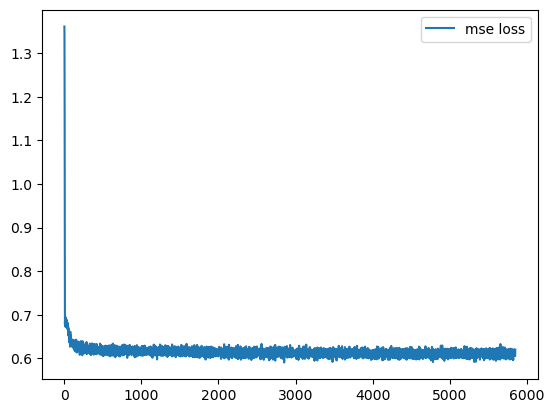

In [20]:
# plot loss
import matplotlib.pyplot as plt
# plt.plot(step_list, loss_list, label='total loss')
plt.plot(step_list, mse_loss_list, label='mse loss')
# plt.plot(step_list, kld_loss_list, label='kld loss')
plt.legend()
plt.show()


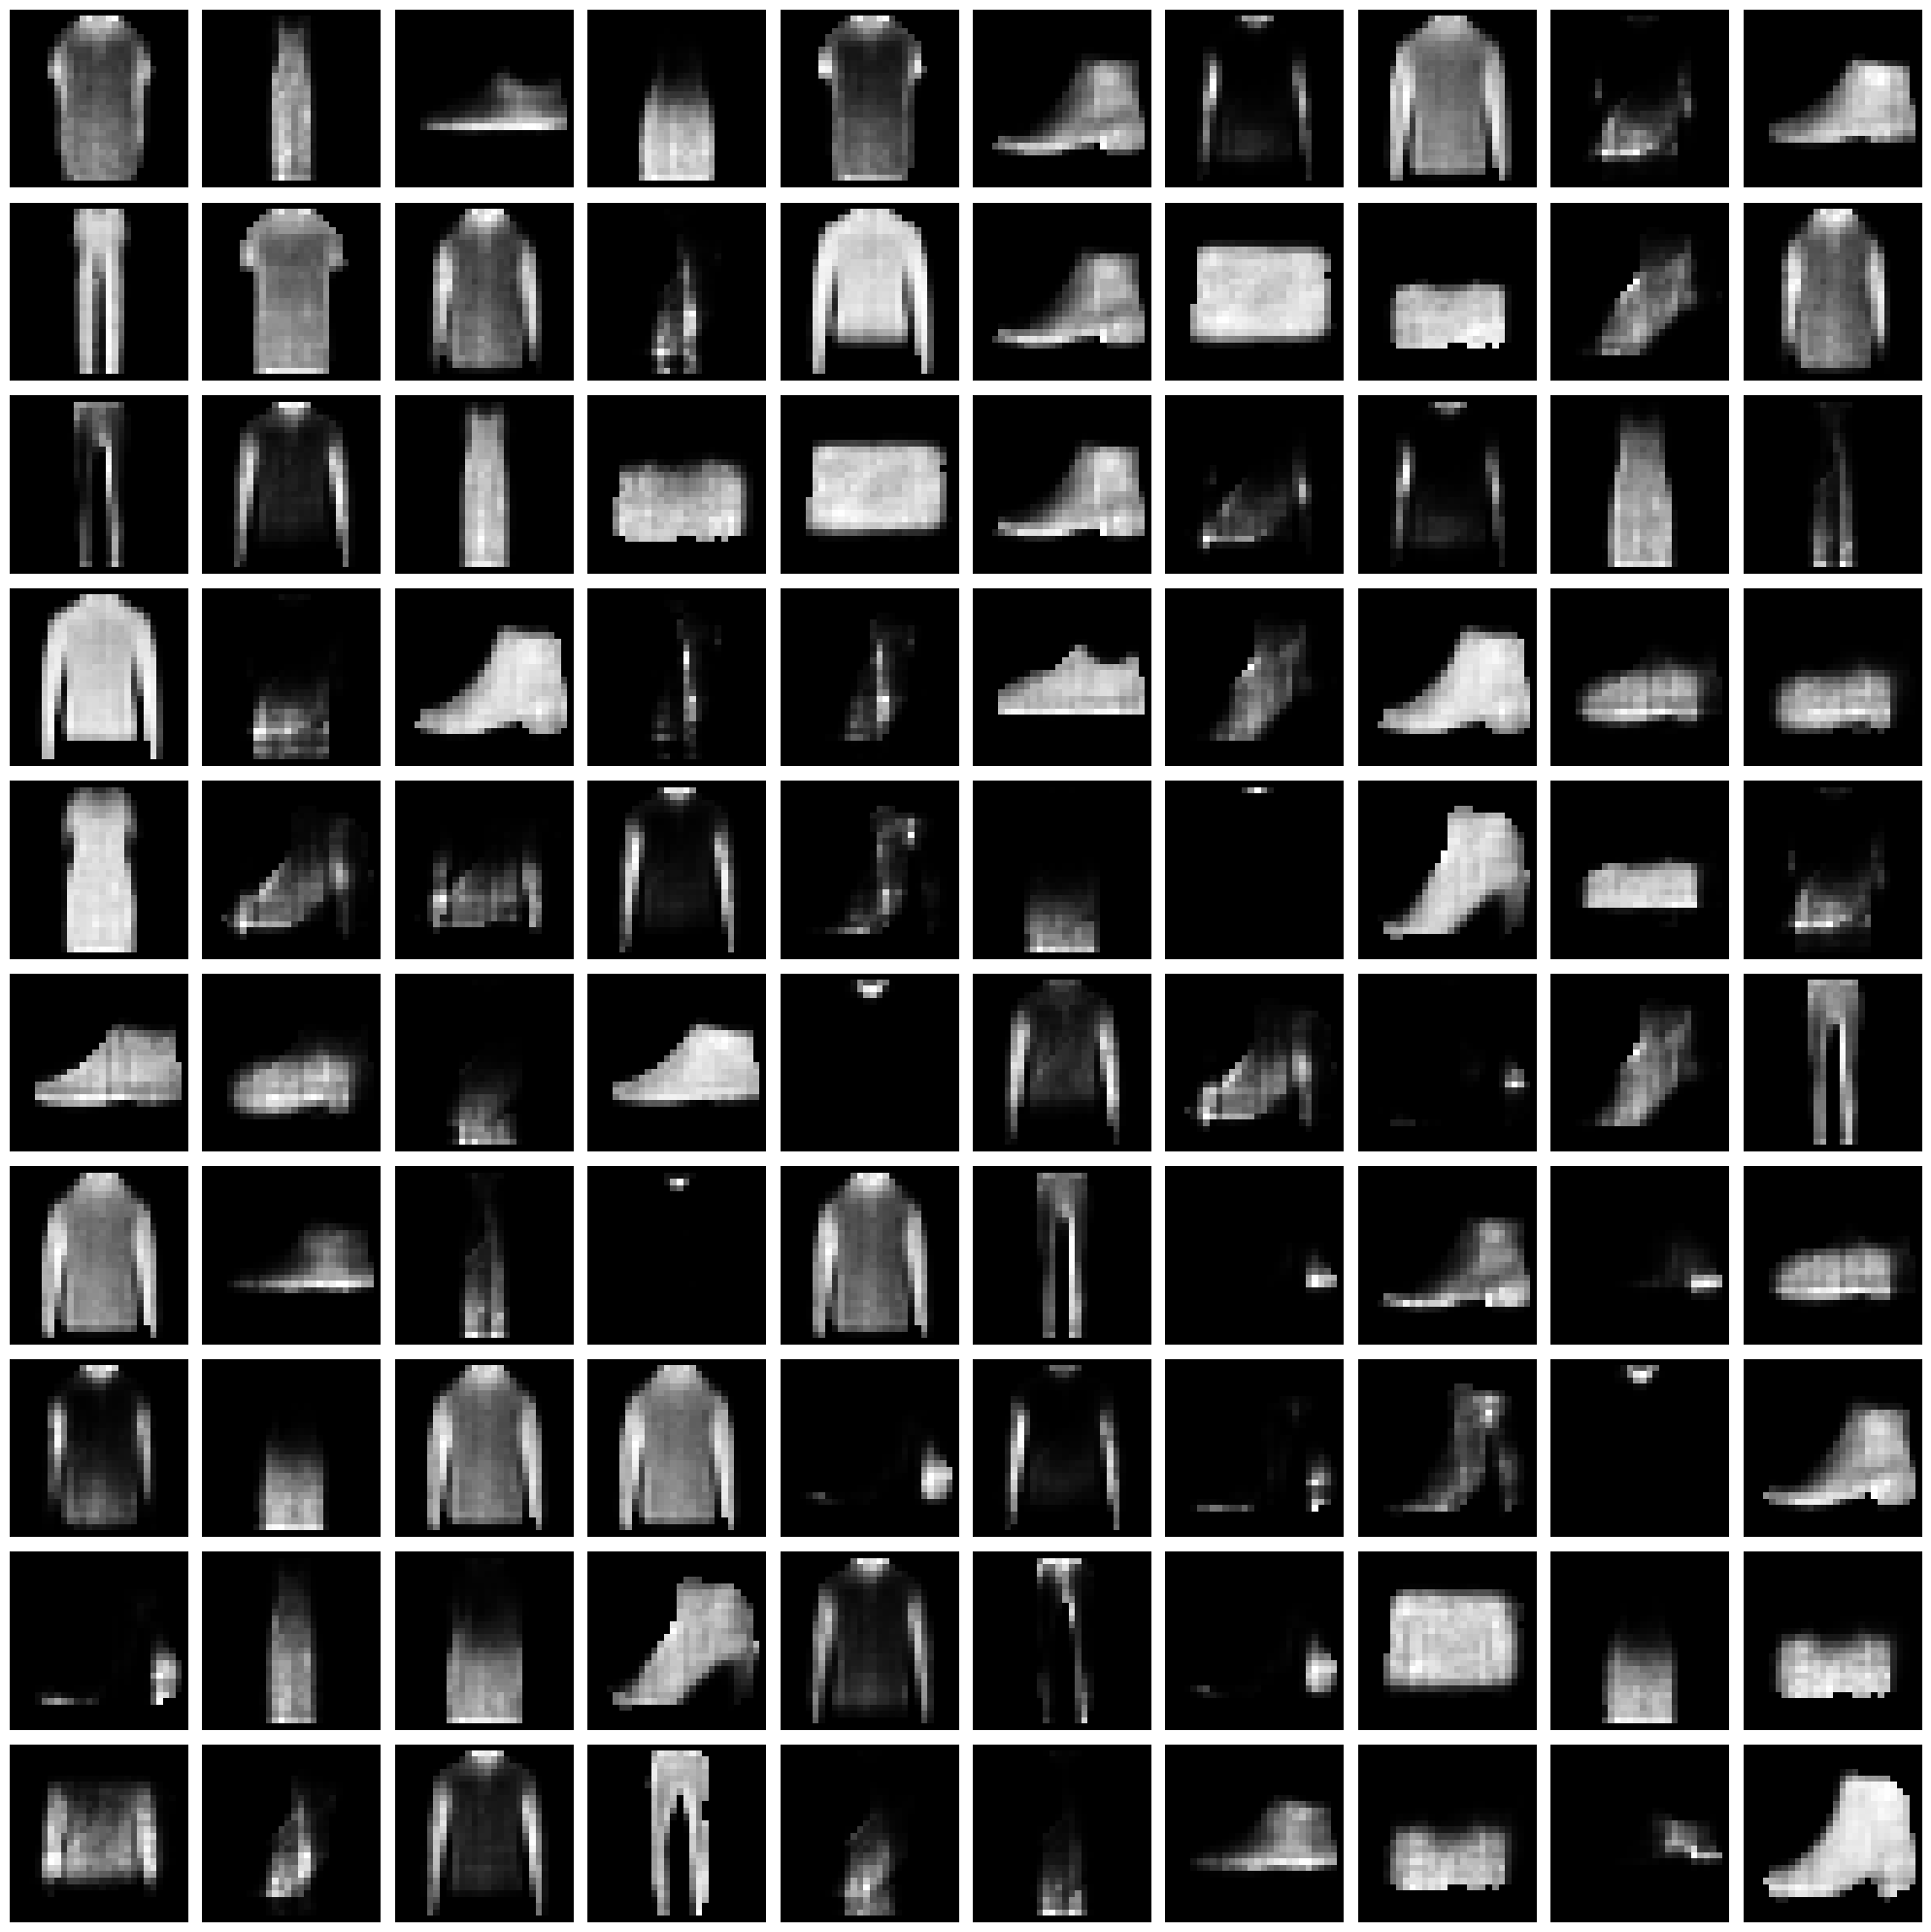

In [22]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# 设置模型为评估模式
vae.eval()

# 创建一个大图
plt.figure(figsize=(20, 20))

# 生成样本数量
n_samples = 10
n_rows = 10

# 存储生成的图像
generated_images = torch.zeros(n_rows, n_samples, 28, 28)

with torch.no_grad():
    # 生成多个样本
    for i in range(n_rows):
        for j in range(n_samples):
            # 从标准正态分布采样潜在变量
            z = torch.randn(1, 2).cuda()
            # 通过解码器生成图像
            sample = vae.decoder(z)
            # 保存生成的图像
            generated_images[i, j] = sample.view(28, 28).cpu()

# 绘制网格图
for i in range(n_rows):
    for j in range(n_samples):
        plt.subplot(n_rows, n_samples, i*n_samples + j + 1)
        plt.imshow(generated_images[i, j], cmap='gray')
        plt.axis('off')

plt.tight_layout()
plt.show()

# 保存一些样本图像
# with torch.no_grad():
#     z = torch.randn(64, 2).cuda()
#     samples = vae.decoder(z)
#     save_image(samples.view(64, 1, 28, 28), './vae_samples.png', nrow=8)

In [26]:
# 拿到所有train_sample的latent space
z_list = []
with torch.no_grad():
    for data, target in train_loader:
        data = data.to("cuda:0")
        mu, log_var = vae.encoder(data.view(-1, 784))
        z = vae.reparameterize_sampling(mu, log_var)
        z_list.append([z,target])

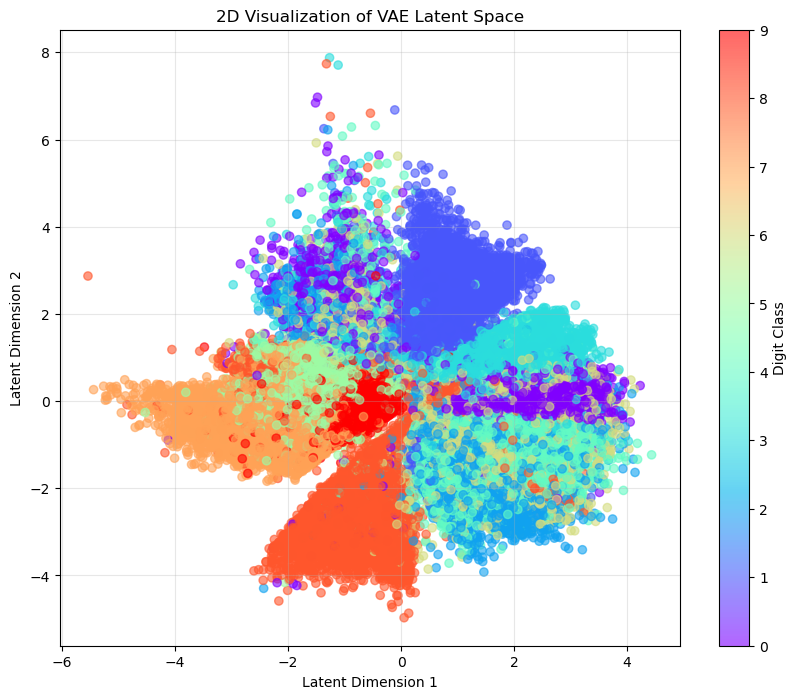

In [29]:
# 2D 可视化
import matplotlib.pyplot as plt
import numpy as np

# 将CUDA张量转移到CPU并转换为numpy数组
all_point = torch.cat([z.cpu() for z, _ in z_list], dim=0).numpy()
label = np.concatenate([target.cpu().numpy() for _, target in z_list])

plt.figure(figsize=(10, 8))
plt.scatter(all_point[:,0], all_point[:,1], c=label, cmap='rainbow', alpha=0.6)
plt.colorbar(label='Digit Class')
plt.title('2D Visualization of VAE Latent Space')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
# fashion_mnist_labels = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot"
# }